## Folder Structure:

Make sure data structure looks like this.

```
|-- data_slices
    |-- train
        |-- masks
            |-- img
        |-- slices
            |-- img
            
    |-- valid
        |-- masks
            |-- img
        |-- slices
            |-- img
```

## Environment setup

In [1]:
# Import modules

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

Note that I added ConfigProto lines at the end. I added these after my cuDNN failed to initialize. Adding these lines resolves the issue.

In [2]:
# Check gpu avalability
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# Define paths and constants

SEED = 909
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALID = 4
EPOCHS = 20

IMG_HEIGHT = 128 # Original is 512, be we down size for speed
IMG_WIDTH = 128
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

NUM_TRAIN = 176884 # Got from generator below
NUM_VALID = 23298


DATA_ROOT = 'E:/skia_projects/ct_segmentation_3d/data_slices'
trainDir = os.path.join(DATA_ROOT, 'train')
train_images = os.path.join(trainDir, 'slices')
train_masks = os.path.join(trainDir, 'masks')

valDir = os.path.join(DATA_ROOT, 'valid')
val_images = os.path.join(valDir, 'slices')
val_masks = os.path.join(valDir, 'masks')

## Helper functions

In [4]:
# Utility to feed data from directory to neural network

# Train generator
def create_seg_generator_train(img_path, mask_path, BATCH_SIZE):
   
    data_gen_args = dict(rescale=1./255,
                        rotation_range=90,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        zoom_range=0.3)
    
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = datagen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    
    return zip(img_generator, mask_generator)

# Remember not to perform any image augmentation in the test generator!
def create_seg_generator_test(img_path, mask_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = datagen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, mask_generator)

In [5]:
train_generator = create_seg_generator_train(train_images, train_masks, BATCH_SIZE_TRAIN)

Found 176884 images belonging to 1 classes.
Found 176884 images belonging to 1 classes.


In [6]:
val_generator = create_seg_generator_test(val_images, val_masks, BATCH_SIZE_VALID)

Found 23298 images belonging to 1 classes.
Found 23298 images belonging to 1 classes.


In [7]:
def display(display_list):
    plt.figure(figsize=(10,10))
    title = ['Input image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [8]:
def show_dataset(datagen, num_items=1):
    for i in range(0, num_items):
        image, mask = next(datagen)
        display([image[0], mask[0]])

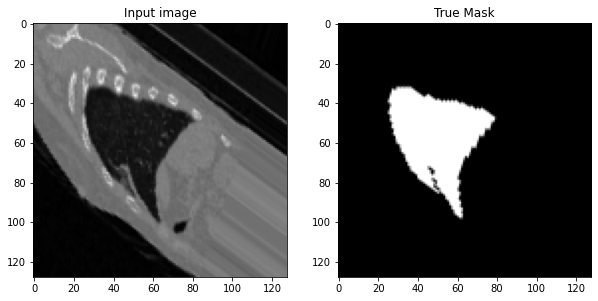

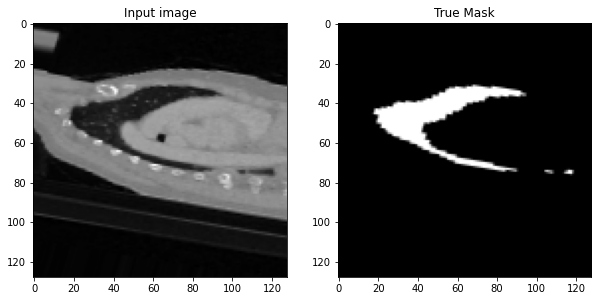

In [16]:
show_dataset(train_generator, 2)

## Model

In [10]:
def unet(n_levels, n_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    
    inputs = keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, in_channels))
    x = inputs
    
    conv_paras = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    # downstream
    skips = {} # save skip connections
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(n_features * 2 ** level, **conv_paras)(x)
        if level < n_levels-1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(n_features * 2 ** level, strides=pooling_size, **conv_paras)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(n_features * 2 ** level, **conv_paras)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{n_features}')

In [11]:
# Initialize the model
model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

## Training 

In [13]:
# Define some training parameters
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALID = NUM_VALID // BATCH_SIZE_VALID

checkpoint = ModelCheckpoint(f'lung_segmentation_{IMG_HEIGHT}_{IMG_WIDTH}.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [14]:
# Train the model
model.fit(train_generator, 
          steps_per_epoch=EPOCH_STEP_TRAIN, 
          validation_data=val_generator, 
          validation_steps=EPOCH_STEP_VALID,
          epochs=EPOCHS,
          callbacks=[checkpoint, es])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 44221 steps, validate for 5824 steps
Epoch 1/20
44218/44221 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9619
Epoch 00001: val_accuracy improved from -inf to 0.99718, saving model to UNET-ToothSegmentation_128_128.h5
44221/44221 [==============================] - 1188s 27ms/step - loss: 0.0162 - accuracy: 0.9619 - val_loss: 0.0083 - val_accuracy: 0.9972
Epoch 2/20
44219/44221 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9627
Epoch 00002: val_accuracy did not improve from 0.99718
44221/44221 [==============================] - 1238s 28ms/step - loss: 0.0129 - accuracy: 0.9627 - val_loss: 0.0086 - val_accuracy: 0.9970
Epoch 3/20
44219/44221 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9628
Epoch 00003: val_accuracy did not improve from 0.99718
44221/44221 [==============================] - 1240s 28ms/step - loss: 0.0121 - accuracy: 0.9628 - val_loss:

In [ ]:
# Save final model as well
model.save(f'lung_segmentation_{IMG_HEIGHT}_{IMG_WIDTH}_final.h5')

## Visualize validation predictions

In [15]:
val_generator = create_seg_generator_test(val_images, val_masks, 1)

Found 23298 images belonging to 1 classes.
Found 23298 images belonging to 1 classes.


In [16]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

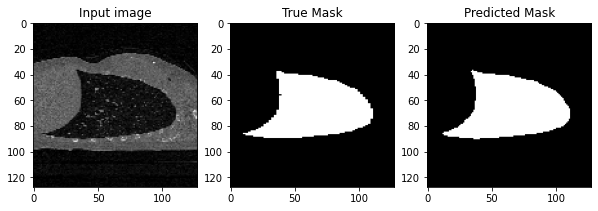

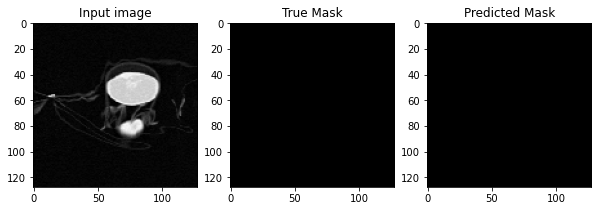

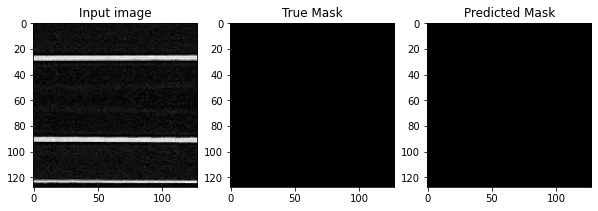

In [17]:
show_prediction(val_generator, 3)